##Задание
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats

In [14]:
from math import asin
from typing import Union
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.meta_analysis import effectsize_smd
from statsmodels.stats import proportion
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.power import zt_ind_solve_power

from google_drive_downloader import GoogleDriveDownloader as gdd

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [15]:
def continious_result(control: pd.DataFrame,
                      test: pd.DataFrame,
                      column: str,
                      n_iters: int = 10_000) -> pd.DataFrame:
    # Статистика по выборкам
    size = control.loc[:, column].shape[0]
    
    control_mean = control.loc[:, column].mean()
    test_mean = test.loc[:, column].mean()
    
    control_std = control.loc[:, column].std(ddof=1)
    test_std = test.loc[:, column].std(ddof=1)
    
    # Бутсрап
    booted_diff = []
    for _ in tqdm(range(n_iters)):
        control_sample = control.loc[:, column].sample(n=size, replace=True).values
        test_sample = test.loc[:, column].sample(n=size, replace=True).values
        booted_diff.append(np.mean(control_sample - test_sample))
    
    # Считаем статистику после бустрапа
    md_ci, std_ci = np.mean(booted_diff), np.std(booted_diff, ddof=1)
    left_ci, right_ci = np.percentile(booted_diff, [2.5, 97.5])
    p_value_ci = 2 * (1 - stats.norm.cdf(np.abs(md_ci / std_ci)))
    
    # Считаем мощность эксперимента
    effect_size, _ = effectsize_smd(mean1=test_mean, sd1=test_std, nobs1=size,
                                    mean2=control_mean, sd2=control_std, nobs2=size)
    power = tt_ind_solve_power(effect_size=effect_size,
                               nobs1=size,
                               alpha=.05,
                               power=None,
                               ratio=1)
    # Формируем отчёт 
    result = pd.DataFrame({'effect_size': effect_size,
                           'alpha': p_value_ci, 
                           'beta': (1-power),
                           'CI': f'[{np.round(left_ci, 3)}, {np.round(right_ci, 3)}]',
                           'difference': md_ci,},
                          index=[column]) 
    return result

In [16]:
def proportion_result(control: pd.DataFrame,
                      test: pd.DataFrame,
                      column: str,
                      n_iters: int = 10_000) -> pd.DataFrame:
    # Вероятность событий
    size = control.loc[:, column].shape[0]
    prop_control = control.loc[:, column].sum() / size
    prop_test = test.loc[:, column].sum() / size
    
    # Бутсрап
    booted_diff = []
    for _ in tqdm(range(n_iters)):
        control_sample = stats.bernoulli.rvs(p=prop_control, size=size)
        test_sample = stats.bernoulli.rvs(p=prop_test, size=size)
        booted_diff.append(np.mean(control_sample - test_sample))
    
    # Считаем статистику после бустрапа
    md_ci, std_ci = np.mean(booted_diff), np.std(booted_diff, ddof=1)
    left_ci, right_ci = np.percentile(booted_diff, [2.5, 97.5])
    p_value_ci = 2 * (1 - stats.norm.cdf(np.abs(md_ci / std_ci)))
    
    # Считаем мощность эксперимента
    effect_size = proportion.proportion_effectsize(prop_control, prop_test)
    power = zt_ind_solve_power(effect_size=effect_size,
                               nobs1=size,
                               alpha=.05,
                               power=None,
                               ratio=1)
    # Формируем отчёт 
    result = pd.DataFrame({'effect_size': effect_size,
                           'alpha': p_value_ci, 
                           'beta': (1-power),
                           'CI': f'[{np.round(left_ci, 3)}, {np.round(right_ci, 3)}]',
                           'difference': md_ci,},
                          index=[column]) 
    return result

In [17]:
gdd.download_file_from_google_drive(file_id='18_noiPSO6GPzSVTExlV97XY5NqeHniRY',
                                    dest_path='./data/gb_sem_9_hw.csv',
                                    unzip=False)
df = pd.read_csv('./data/gb_sem_9_hw.csv')

In [18]:
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [20]:
#дубли отсутствуют
df.userid.nunique()

90189

In [30]:
#распределение по группам
df.groupby('version')['sum_gamerounds'].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


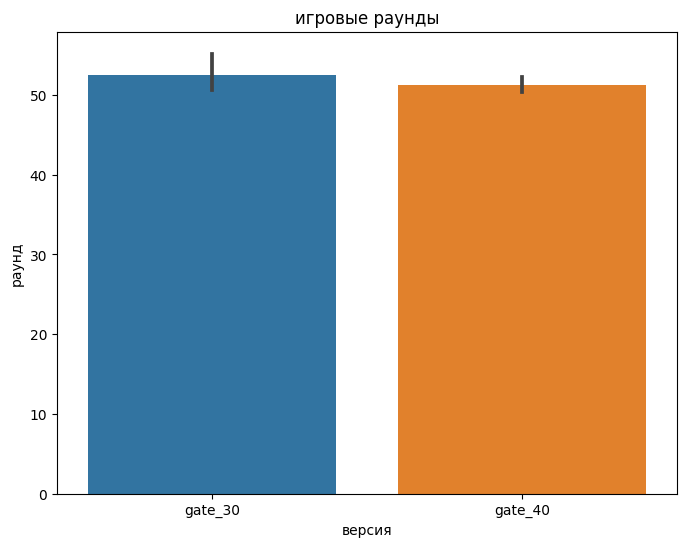

In [28]:
plt.figure(figsize=(8, 6))
sns.barplot(x = df['version'], y = df['sum_gamerounds']);
plt.title('игровые раунды')
plt.xlabel('версия')
plt.ylabel('раунд');

In [31]:
control = df[df['version'] == 'gate_30'].copy(deep = True)
variant = df[df['version'] == 'gate_40'].copy(deep = True)

In [32]:
#sum_gamerounds непрерывная метрика.
continious_result(control, variant, column='sum_gamerounds')

100%|██████████| 10000/10000 [00:36<00:00, 270.74it/s]


,effect_size,alpha,beta,CI,difference
sum_gamerounds,-0.005915,0.38136,0.856725,"[-1.021, 4.07]",1.154266


##Вывод
Различия между контрольной и тестовой группой статитсически не значимы, доверительный интервал проходит через ноль, alpha и beta велики.

In [33]:
#retention_1 качественная метрика.
proportion_result(control, variant, column='retention_1')

100%|██████████| 10000/10000 [00:39<00:00, 254.58it/s]


,effect_size,alpha,beta,CI,difference
retention_1,-0.003823,0.564105,0.911819,"[-0.008, 0.005]",-0.001929


##Вывод
Различия между контрольной и тестовой группой статитсически не значимы, доверительный интервал проходит через ноль, alpha и beta велики.

In [34]:
#retention_7 качественная метрика.
proportion_result(control, variant, column='retention_1')

100%|██████████| 10000/10000 [00:38<00:00, 259.01it/s]


,effect_size,alpha,beta,CI,difference
retention_1,-0.003823,0.56292,0.911819,"[-0.008, 0.004]",-0.001897


##Вывод
Различия между контрольной и тестовой группой статитсически не значимы, доверительный интервал проходит через ноль, alpha и beta велики.

##Вывод
Выводить изменения на продакшен не рекомендованно, они не дадут ни какого эффекта.